In [1]:
# Import torch
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as TF
from torchvision import transforms
from torch.utils.data import Dataset

# Import fundamentals
import os
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def create_image_transform(custom_transform=None):
    """
    Create a composite transform consisting of standard transformations and an optional custom transformation.
    
    Args:
    custom_transform (callable, optional): An additional transform to be applied after the standard transformations.
    
    Returns:
    torchvision.transforms.Compose: A composite transform.
    """
    default_transforms = [
        transforms.Resize((224, 224)),  # Resize all images to 224x224
        transforms.ToTensor()           # Convert images to tensor format
    ]
    
    # If there is an additional transform provided by the user, append it to the list
    if custom_transform is not None:
        default_transforms.append(custom_transform)
    
    # Compose all the transforms into a single pipeline
    return transforms.Compose(default_transforms)

# def debug_transform(x):
#     print("Unique values post-transform:", x.unique())
#     return x

def create_mask_transform():
    return transforms.Compose([
        transforms.Resize((224, 224), interpolation=Image.NEAREST),
        transforms.ToTensor(),
        lambda x: torch.clamp(x * 255 - 1, min=0, max=2)#debug_transform  # Add this to check the distribution of values
    ])

def show_masks_comparison(ground_masks, predicted_masks, num_images=3):
    fig, axs = plt.subplots(num_images, 2, figsize=(10, 10))  # Adjust the layout: num_images rows, 2 columns

    for i in range(num_images):
        # Display the ground truth mask
        axs[i, 0].imshow(ground_masks[i].squeeze(), cmap='gray')  # Assume ground_masks are [num_images, 1, h, w]
        axs[i, 0].set_title('Ground Truth Mask')
        axs[i, 0].axis('off')

        # Display the predicted mask
        axs[i, 1].imshow(predicted_masks[i].squeeze(), cmap='gray')  # Assume predicted_masks are [num_images, h, w]
        axs[i, 1].set_title('Predicted Mask')
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

In [3]:
class OxfordPetsDataset(Dataset):
    def __init__(self, root_dir, split, image_transform=None, mask_transform=None, seed=None):
        """
        Initializes the dataset.

        Args:
        root_dir: Directory with all the dataset images and masks.
        split: One of 'train', 'val', or 'test' to select the data split.
        transform: Optional custom transform to be applied on a sample.
        """

        # Set seed
        if seed is not None:
            self.set_seed(seed)

        # Initialise variables
        self.root_dir = root_dir
        self.split = split
        self.image_transform = image_transform
        self.mask_transform = mask_transform

        # Set up paths
        images_path = os.path.join(root_dir, 'OxfordPet/images')
        masks_path = os.path.join(root_dir, 'OxfordPet/annotations/trimaps')
        
        # Split into training, validation and test data set
        random.seed(seed)
        all_images = [img for img in os.listdir(images_path) if img.endswith('.jpg')]
        random.shuffle(all_images)
        num_images = len(all_images)
        train_end = int(0.7 * num_images)
        val_end = train_end + int(0.15 * num_images)
        
        if split == 'train':
            image_filenames = all_images[:train_end]
        elif split == 'val':
            image_filenames = all_images[train_end:val_end]
        elif split == 'test':
            image_filenames = all_images[val_end:]
        else:
            raise ValueError("Unknown split: {}. Expected 'train', 'val', or 'test'.".format(split))

        # Get images and masks for respective data set
        self.images = [os.path.join(images_path, fname) for fname in image_filenames]
        self.masks = [os.path.join(masks_path, fname.replace('.jpg', '.png')) for fname in image_filenames]

    def __len__(self):
        return len(self.images)
    
    def set_seed(self, seed):
        random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    def __getitem__(self, idx):
        # Get image and mask paths
        image_path = self.images[idx]

        # Open image as RGB and mask
        mask_path = self.masks[idx]
        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        # Apply transformations to the image
        if self.image_transform:
            image = self.image_transform(image)
        
        # Apply mask_transform to the mask
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

In [4]:
# dataset
dataset = OxfordPetsDataset(root_dir='/cs/student/projects3/COMP0197/grp3/adl_groupwork/adl_supervised_learning/', split='train', image_transform=create_image_transform(), mask_transform=create_mask_transform(), seed=42)

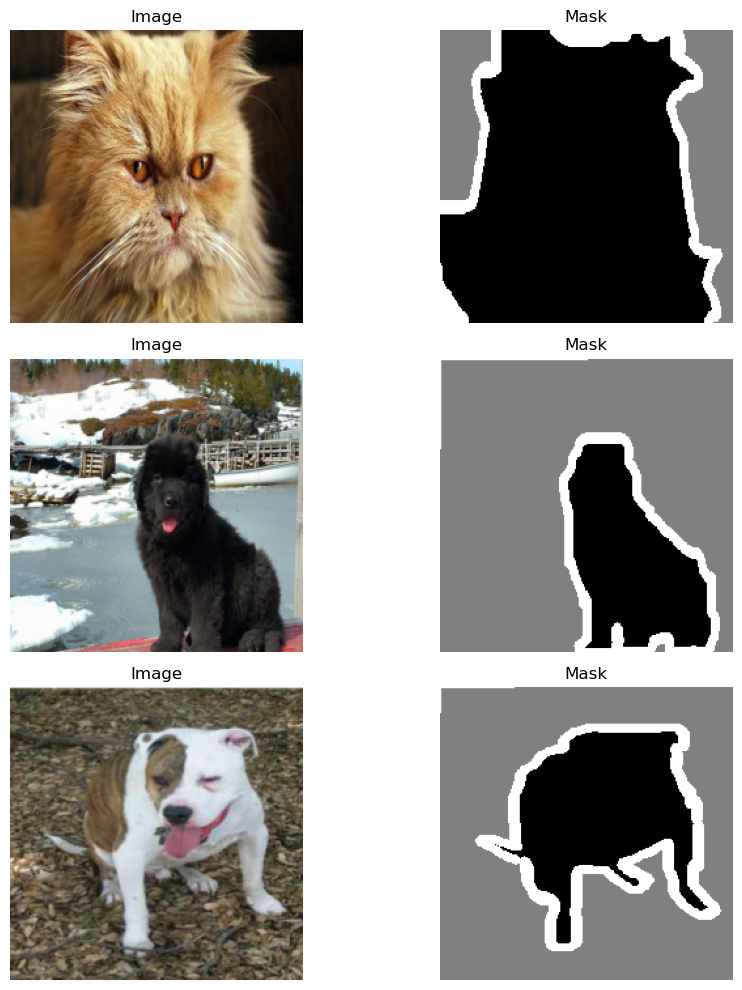

In [5]:
# Function to display images and masks
def show_images_with_masks(dataset, num_images=3):
    fig, axs = plt.subplots(num_images, 2, figsize=(10, 10))  # Create a grid for displaying images and masks
    for i in range(num_images):
        image, mask = dataset[i + 22]  # Adjust index based on your dataset structure

        # Display the image
        axs[i, 0].imshow(image.permute(1, 2, 0))  # Adjust the tensor for display (channel last)
        axs[i, 0].set_title('Image')
        axs[i, 0].axis('off')  # Hide axes for cleaner display

        # Display the mask
        axs[i, 1].imshow(mask.squeeze(), cmap='gray')  # Remove channel dimension for mask and apply gray colormap
        axs[i, 1].set_title('Mask')
        axs[i, 1].axis('off')  # Hide axes for cleaner display

    plt.tight_layout()  # Adjust layout so images and masks do not overlap
    plt.show()  # Show the plot

# Plot images with masks
show_images_with_masks(dataset)

# Predict image segmentation mask

In [6]:
import sys
sys.path.append('../models')

# Import resnet
from resnet import *

In [7]:
# Test data set
test_dataset = OxfordPetsDataset(root_dir='/cs/student/projects3/COMP0197/grp3/adl_groupwork/adl_supervised_learning/', split='train', image_transform=create_image_transform(), mask_transform=create_mask_transform(), seed=42)

# Initialise model
model = ResNetSegmentation(3)

# Load model
epoch = 80
model_path = f'/cs/student/projects3/COMP0197/grp3/adl_groupwork/adl_supervised_learning/model_checkpoints/model_checkpoint_epoch{epoch}.pth' 
model.load_state_dict(torch.load(model_path))

# Set model to evaluation mode
model.eval()

/cs/student/projects3/COMP0197/grp3/adl_groupwork/mae/env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/cs/student/projects3/COMP0197/grp3/adl_groupwork/mae/env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNetSegmentation(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

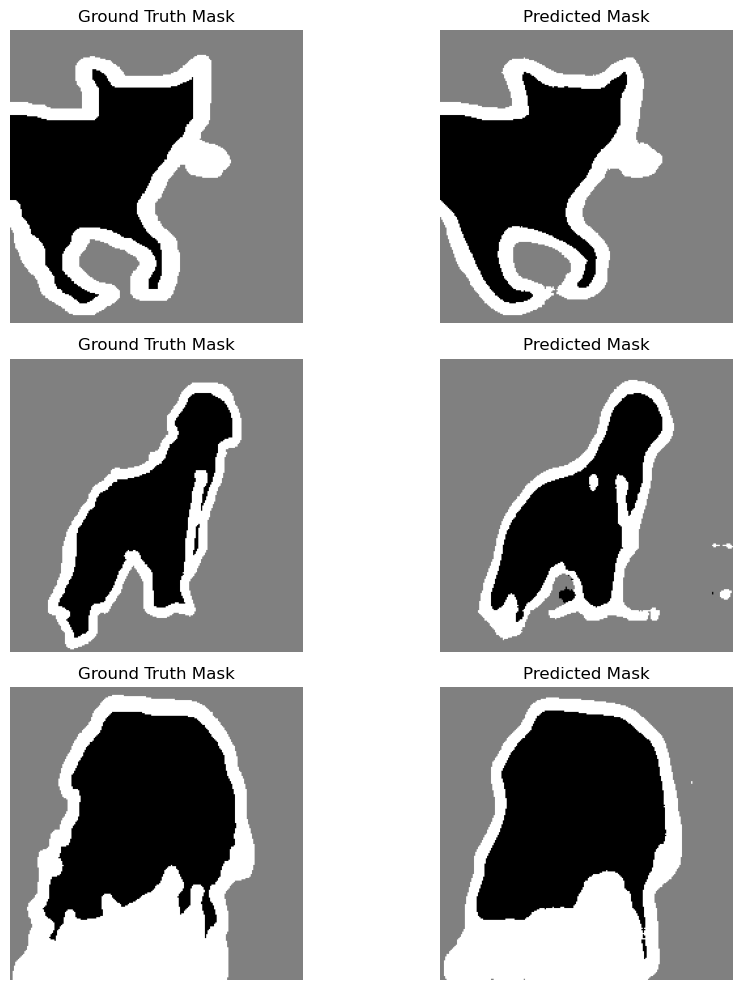

In [8]:
# Initialize the DataLoader with the test dataset
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True)

# Loop through the test loader
for images, ground_masks in test_loader:

    # Send images through the model
    outputs = model(images)

    # Predict class
    _, predicted_masks = torch.max(outputs, 1)

    # Print 
    show_masks_comparison(ground_masks, predicted_masks, num_images=3)

    break

In [9]:
def IoUMetric(pred, gt, softmax=False):

    pred=torch.argmax(pred,dim=1,keepdim=True)
    pred = torch.cat([ (pred == 0)], dim=1)
    #Add channel dimension to targets that was removed when computing CE loss in line 136
    gt=gt[:,None,:,:]

    gt = torch.cat([ (gt == 0)], dim=1)


    intersection = torch.logical_and(gt,pred)
    union = torch.logical_or(gt,pred)

    # Compute the sum over all the dimensions except for the batch dimension.
    iou = (intersection.sum(dim=(1, 2, 3)) + 0.001) / (union.sum(dim=(1, 2, 3)) + 0.001)
    
    # Compute the mean over the batch dimension.
    return iou.mean()

In [12]:
def IoUMetric(pred, gt, softmax=False):

    pred = torch.cat([ (pred == 0)], dim=1)
    #Add channel dimension to targets that was removed when computing CE loss in line 136
    gt=gt[:,None,:,:]

    gt = torch.cat([ (gt == 0)], dim=1)


    intersection = torch.logical_and(gt,pred)
    union = torch.logical_or(gt,pred)

    # Compute the sum over all the dimensions except for the batch dimension.
    iou = (intersection.sum(dim=(1, 2, 3)) + 0.001) / (union.sum(dim=(1, 2, 3)) + 0.001)
    
    # Compute the mean over the batch dimension.
    return iou.mean()

In [10]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
# --------------------------------------------------------
# References:
# DeiT: https://github.com/facebookresearch/deit
# --------------------------------------------------------

import os
import random # added this to call the seed
import PIL

import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset

from PIL import Image

from timm.data import create_transform
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD


def build_dataset(is_train, args):
    transform = build_transform(is_train, args)

    root = os.path.join(args.data_path, 'animals' if is_train else 'non_animals')
    dataset = datasets.ImageFolder(root, transform=transform)

    return dataset


def build_transform(is_train, args):
    mean = IMAGENET_DEFAULT_MEAN # Judy: need to change these (not using imagenet)
    std = IMAGENET_DEFAULT_STD
    # train transform
    if is_train:
        # this should always dispatch to transforms_imagenet_train
        transform = create_transform(
            input_size=args.input_size,
            is_training=True,
            color_jitter=args.color_jitter,
            auto_augment=args.aa,
            interpolation='bicubic',
            re_prob=args.reprob,
            re_mode=args.remode,
            re_count=args.recount,
            mean=mean,
            std=std,
        )
        return transform

    # eval transform
    t = []
    if args.input_size <= 224:
        crop_pct = 224 / 256
    else:
        crop_pct = 1.0
    size = int(args.input_size / crop_pct)
    t.append(
        transforms.Resize(size, interpolation=PIL.Image.BICUBIC),  # to maintain same ratio w.r.t. 224 images
    )
    t.append(transforms.CenterCrop(args.input_size))

    t.append(transforms.ToTensor())
    t.append(transforms.Normalize(mean, std))
    return transforms.Compose(t)


class OxfordPetsDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, seed=None):
        """
        Initializes the dataset.

        Args:
        root_dir: Directory with all the dataset images and masks.
        split: One of 'train', 'val', or 'test' to select the data split.
        transform: Optional custom transform to be applied on a sample.
        """

        # Set seed
        if seed is not None:
            self.set_seed(seed)


        self.root_dir = root_dir
        self.split = split
        # Combine the default resize transformation with the conversion to tensor
        # Users can pass additional transformations which will be applied after resizing and converting to tensor
        default_transforms = [transforms.Resize((224, 224)), transforms.ToTensor()]
        if transform is not None:
            default_transforms.append(transform)
        self.transform = transforms.Compose(default_transforms)
        
        # Split into training, validation and test data set
        all_images = [img for img in os.listdir(os.path.join(root_dir, 'images')) if img.endswith('.jpg')]
        random.shuffle(all_images)
        num_images = len(all_images)
        train_end = int(0.7 * num_images)
        val_end = train_end + int(0.15 * num_images)
        
        if split == 'train':
            image_filenames = all_images[:train_end]
        elif split == 'val':
            image_filenames = all_images[train_end:val_end]
        elif split == 'test':
            image_filenames = all_images[val_end:]
        else:
            raise ValueError("Unknown split: {}. Expected 'train', 'val', or 'test'.".format(split))

        self.images = [os.path.join(root_dir, 'images', fname) for fname in image_filenames]
        for i in range(5):
            print(self.images[i])
        self.masks = [os.path.join(root_dir, 'annotations/trimaps', fname.replace('.jpg', '.png')) for fname in image_filenames]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        mask_path = self.masks[idx]
        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transform is not None:
            state = torch.get_rng_state()
            image = self.transform(image)
            torch.set_rng_state(state)
            mask = self.transform(mask)

        mask = self.preprocess_segmentation(mask)

        return image, mask

    def preprocess_segmentation(self, mask):
        thresholds = [0.0, 0.004, 0.008, 0.2]

        processed_mask = torch.zeros_like(mask)

        for i in range(len(thresholds) - 1):
            lower_bound = thresholds[i]
            upper_bound = thresholds[i + 1]
            processed_mask[(mask >= lower_bound) & (mask < upper_bound)] = i

        return processed_mask

    def set_seed(self, seed):
        random.seed(seed)
        torch.manual_seed(seed) # comment out if
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [39]:


def metrics(pred, gt):

    pred=torch.argmax(pred,dim=1,keepdim=True)
    
    # Compute accuracy
    #gt_accuracy=gt[:,None,:,:]
    truth_tensor=torch.eq(pred,gt)
    accuracy=100*torch.count_nonzero(truth_tensor.long())/torch.numel(pred)

    # Compute IOU


    pred = torch.cat([ (pred == 0)], dim=1)
    #Add channel dimension to targets that was removed when computing CE loss in line 136

    gt = torch.cat([ (gt == 0)], dim=1)


    intersection = torch.logical_and(gt,pred)
    union = torch.logical_or(gt,pred)

    # Compute the sum over all the dimensions except for the batch dimension.
    iou = (intersection.sum(dim=(1, 2, 3)) + 0.001) / (union.sum(dim=(1, 2, 3)) + 0.001)
    
    # Compute the mean over the batch dimension for the iou.
    return iou.mean(), accuracy

../../OxfordPet/images/Russian_Blue_45.jpg
../../OxfordPet/images/Ragdoll_115.jpg
../../OxfordPet/images/shiba_inu_157.jpg
../../OxfordPet/images/miniature_pinscher_18.jpg
../../OxfordPet/images/Ragdoll_69.jpg


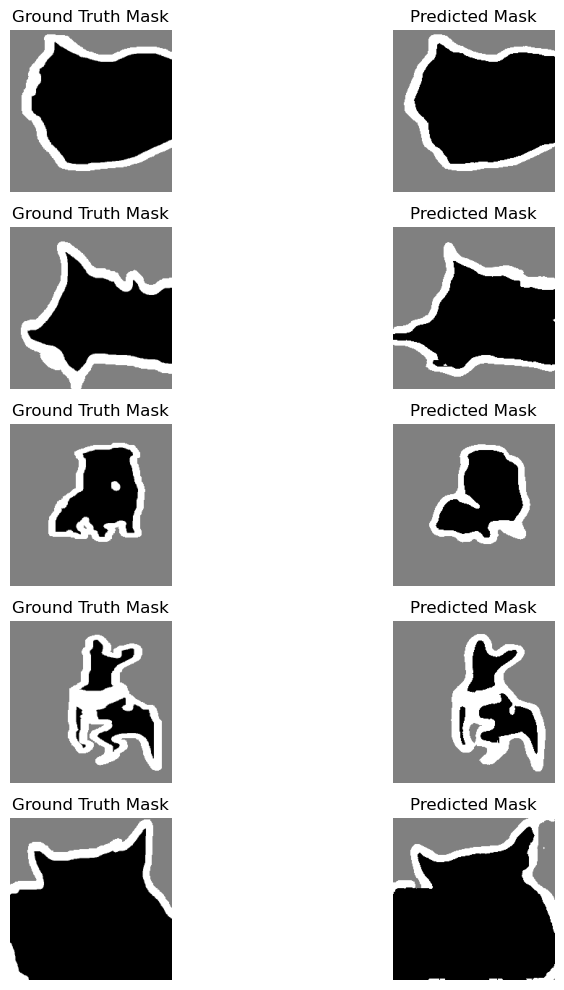

iou: 0.8990609645843506, acc: 94.87411499023438


In [42]:
# Test data set
test_dataset = OxfordPetsDataset(root_dir='../../OxfordPet', split='test', seed=42)


# Initialize the DataLoader with the test dataset
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
# Initialise model
model = ResNetSegmentation(3)

# Load model
epoch = 99
model_path = f'../model_checkpoints/model_checkpoint_epoch{epoch}.pth' 
model.load_state_dict(torch.load(model_path))

# Set model to evaluation mode
model.eval()
plotted = False
# Loop through the test loader
total_iou = 0
total_acc = 0
batches = 0

for images, ground_masks in test_loader:
    batches += 1
    # Send images through the model
    outputs = model(images)

    # Predict class
    _, predicted_masks = torch.max(outputs, 1)

    iou, acc = metrics(outputs, ground_masks)
    total_iou += iou
    total_acc += acc

    if not plotted:
        show_masks_comparison(ground_masks, predicted_masks, num_images=5)
        plotted = True
    

print(f"iou: {total_iou / batches}, acc: {total_acc / batches}")

